*****(A)*****

In [ ]:
#  Imports
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import accuracy_score


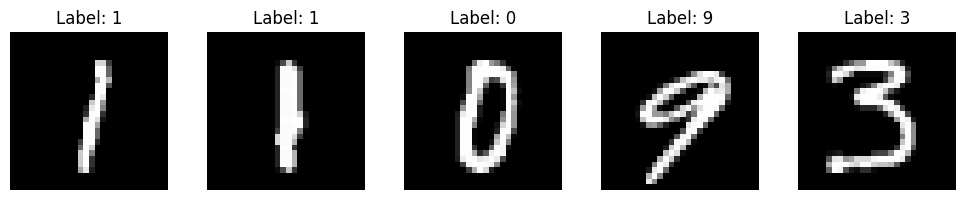

In [ ]:
#  MNIST Data Fetching and Visualization

def fetch_mnist_data(folder_path):
    def parse_images(file_path):
        with open(file_path, 'rb') as f:
            # Read header information
            magic_number = int.from_bytes(f.read(4), 'big')
            num_images = int.from_bytes(f.read(4), 'big')
            num_rows = int.from_bytes(f.read(4), 'big')
            num_cols = int.from_bytes(f.read(4), 'big')
            # Read image data
            images = np.frombuffer(f.read(), dtype=np.uint8)
            images = images.reshape(num_images, num_rows, num_cols)
            return images

    def parse_labels(file_path):
        with open(file_path, 'rb') as f:
            # Read header information
            magic_number = int.from_bytes(f.read(4), 'big')
            num_labels = int.from_bytes(f.read(4), 'big')
            # Read label data
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            return labels

    # Fetch training data
    train_images = parse_images(os.path.join(folder_path, 'train-images.idx3-ubyte'))
    train_labels = parse_labels(os.path.join(folder_path, 'train-labels.idx1-ubyte'))

    # Fetch test data
    test_images = parse_images(os.path.join(folder_path, 't10k-images.idx3-ubyte'))
    test_labels = parse_labels(os.path.join(folder_path, 't10k-labels.idx1-ubyte'))

    return (train_images, train_labels), (test_images, test_labels)

def display_sample_images(images, labels, num_samples=5):
    """Display sample images from the dataset."""
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(num_samples * 2, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


mnist_directory = "."  # Change to your MNIST data directory
try:
    (train_imgs, train_lbls), (test_imgs, test_lbls) = fetch_mnist_data(mnist_directory)
    display_sample_images(train_imgs, train_lbls)
except FileNotFoundError:
    print("MNIST data files not found. Please ensure they are in the specified directory.")


In [ ]:
#  Activation Functions and Their Derivatives

# Activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    return 1 - np.tanh(x) ** 2

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return (x > 0).astype(float)

def leaky_relu(x):
    return np.where(x > 0, x, 0.01 * x)

def leaky_relu_grad(x):
    dx = np.ones_like(x)
    dx[x < 0] = 0.01
    return dx

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # For numerical stability
    return exps / np.sum(exps, axis=1, keepdims=True)


In [ ]:
#  Weight Initialization Functions

# Weight initialization functions
def zero_init(shape):
    return np.zeros(shape)

def random_init(shape):
    limit = np.sqrt(6 / (shape[0] + shape[1]))
    return np.random.uniform(-limit, limit, size=shape)

def normal_init(shape):
    stddev = np.sqrt(2 / (shape[0] + shape[1]))
    return np.random.normal(0, stddev, size=shape)


In [ ]:
#  NeuralNetwork Class Definition with `print_every`

class NeuralNetwork:
    def __init__(self, N, layers, lr, activation, weight_init, epochs, batch_size):
        self.N = N  # Number of layers
        self.layers = layers  # List specifying the number of neurons in each layer
        self.lr = lr  # Learning rate
        self.activation = activation  # Activation function for hidden layers
        self.weight_init = weight_init  # Weight initialization function
        self.epochs = epochs
        self.batch_size = batch_size
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        for i in range(N - 1):
            weight_shape = (layers[i], layers[i+1])
            self.weights.append(self.weight_init(weight_shape))
            self.biases.append(np.zeros((1, layers[i+1])))
        
        # Activation functions mapping
        self.activation_funcs = {
            'sigmoid': (sigmoid, sigmoid_grad),
            'tanh': (tanh, tanh_grad),
            'relu': (relu, relu_grad),
            'leaky_relu': (leaky_relu, leaky_relu_grad)
        }
        
        self.activation_func, self.activation_grad = self.activation_funcs[activation]
        
        # To store loss histories
        self.train_loss_history = []
        self.val_loss_history = []
        
    def fit(self, X, Y, X_val=None, Y_val=None, print_every=10):
        num_samples = X.shape[0]
        for epoch in range(1, self.epochs + 1):
            # Shuffle the data
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]
            
            epoch_loss = 0  # To accumulate loss over the epoch
            
            for start_idx in range(0, num_samples, self.batch_size):
                end_idx = min(start_idx + self.batch_size, num_samples)
                batch_X = X_shuffled[start_idx:end_idx]
                batch_Y = Y_shuffled[start_idx:end_idx]
                
                # Forward pass
                activations = [batch_X]
                pre_activations = []
                for i in range(self.N - 1):
                    W = self.weights[i]
                    b = self.biases[i]
                    Z = np.dot(activations[-1], W) + b
                    pre_activations.append(Z)
                    if i == self.N - 2:
                        A = softmax(Z)
                    else:
                        A = self.activation_func(Z)
                    activations.append(A)
                    
                # Compute loss (cross-entropy)
                loss = -np.mean(np.sum(batch_Y * np.log(activations[-1] + 1e-8), axis=1))
                epoch_loss += loss * batch_X.shape[0]  # Accumulate weighted loss
                
                # Backward pass
                deltas = []
                delta = activations[-1] - batch_Y  # Assuming one-hot encoded Y
                deltas.append(delta)
                
                for i in reversed(range(self.N - 2)):
                    delta = np.dot(deltas[-1], self.weights[i+1].T) * self.activation_grad(pre_activations[i])
                    deltas.append(delta)
                deltas.reverse()
                
                # Update weights and biases
                for i in range(self.N - 1):
                    dW = np.dot(activations[i].T, deltas[i]) / batch_X.shape[0]
                    db = np.sum(deltas[i], axis=0, keepdims=True) / batch_X.shape[0]
                    self.weights[i] -= self.lr * dW
                    self.biases[i] -= self.lr * db
        
            # Average loss over the epoch
            avg_epoch_loss = epoch_loss / num_samples
            self.train_loss_history.append(avg_epoch_loss)
            
            # Compute validation loss if validation data is provided
            if X_val is not None and Y_val is not None:
                val_loss = self._compute_loss(X_val, Y_val)
                self.val_loss_history.append(val_loss)
                # Print loss only if current epoch is a multiple of print_every
                if epoch % print_every == 0 or epoch == 1 or epoch == self.epochs:
                    print(f"Epoch {epoch}/{self.epochs}, Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
            else:
                # Print loss only if current epoch is a multiple of print_every
                if epoch % print_every == 0 or epoch == 1 or epoch == self.epochs:
                    print(f"Epoch {epoch}/{self.epochs}, Train Loss: {avg_epoch_loss:.4f}")
                    
    def predict_proba(self, X):
        A = X
        for i in range(self.N - 1):
            W = self.weights[i]
            b = self.biases[i]
            Z = np.dot(A, W) + b
            if i == self.N - 2:
                A = softmax(Z)
            else:
                A = self.activation_func(Z)
        return A
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)
    
    def score(self, X, Y):
        predictions = self.predict(X)
        labels = np.argmax(Y, axis=1)  # Assuming Y is one-hot encoded
        accuracy = np.mean(predictions == labels)
        return accuracy
    
    def _compute_loss(self, X, Y):
        probs = self.predict_proba(X)
        loss = -np.mean(np.sum(Y * np.log(probs + 1e-8), axis=1))
        return loss


In [ ]:
# Data Preprocessing and Splitting

def preprocess_mnist(X_train, y_train, X_test, y_test):
    # Ensure that labels are integers
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    # Reshape and scale the data
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0
    
    # Convert labels to one-hot encoding
    n_classes = 10
    y_train_onehot = np.zeros((y_train.size, n_classes))
    y_train_onehot[np.arange(y_train.size), y_train] = 1
    y_test_onehot = np.zeros((y_test.size, n_classes))
    y_test_onehot[np.arange(y_test.size), y_test] = 1
    
    return X_train, y_train_onehot, X_test, y_test_onehot

# Load and preprocess MNIST data
try:
    (X_train, y_train), (X_test, y_test) = fetch_mnist_data("./")  # Ensure MNIST files are in the current directory
except FileNotFoundError:
    print("MNIST data files not found in the specified directory './'. Please ensure the files are present.")
    # Optionally, you can provide instructions or download the data programmatically here
    raise

# Preprocess the data
X_train, y_train, X_test, y_test = preprocess_mnist(X_train, y_train, X_test, y_test)

# Split into train, validation, and test sets
# First split: Train and Temp (Validation + Test)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Second split: Validation and Test from Temp
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 48000
Validation set size: 6000
Test set size: 6000



Training with activation: sigmoid, weight_init: zero_init
Epoch 1/150, Train Loss: 2.3025, Val Loss: 2.3024
Epoch 50/150, Train Loss: 2.3011, Val Loss: 2.3010
Epoch 100/150, Train Loss: 2.3011, Val Loss: 2.3010
Epoch 150/150, Train Loss: 2.3011, Val Loss: 2.3010


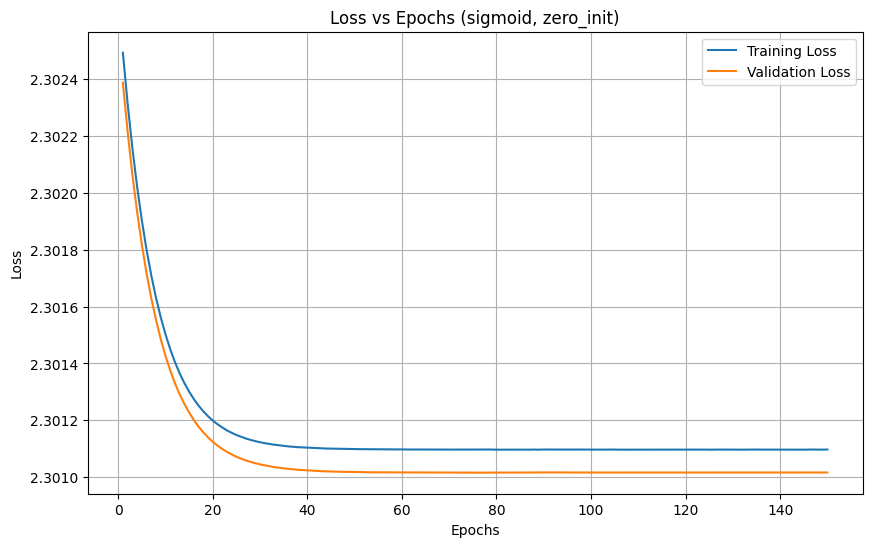

Training completed for activation: sigmoid, weight_init: zero_init
Model saved as model_sigmoid_zero_init.pkl
Loss curve displayed above.

Training with activation: sigmoid, weight_init: random_init
Epoch 1/150, Train Loss: 2.4236, Val Loss: 2.4209
Epoch 50/150, Train Loss: 2.3005, Val Loss: 2.3006
Epoch 100/150, Train Loss: 2.3002, Val Loss: 2.3001
Epoch 150/150, Train Loss: 2.2999, Val Loss: 2.2999


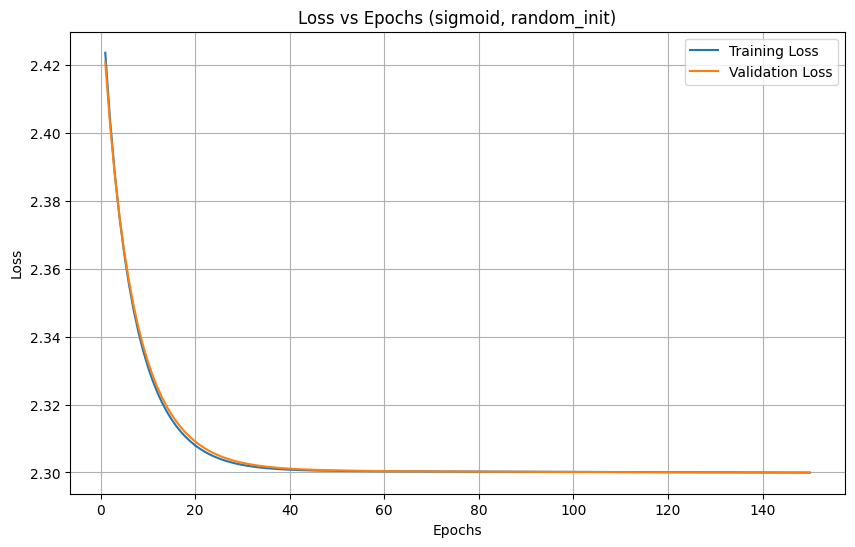

Training completed for activation: sigmoid, weight_init: random_init
Model saved as model_sigmoid_random_init.pkl
Loss curve displayed above.

Training with activation: sigmoid, weight_init: normal_init
Epoch 1/150, Train Loss: 2.3895, Val Loss: 2.3835
Epoch 50/150, Train Loss: 2.3013, Val Loss: 2.3013
Epoch 100/150, Train Loss: 2.3009, Val Loss: 2.3008
Epoch 150/150, Train Loss: 2.3006, Val Loss: 2.3005


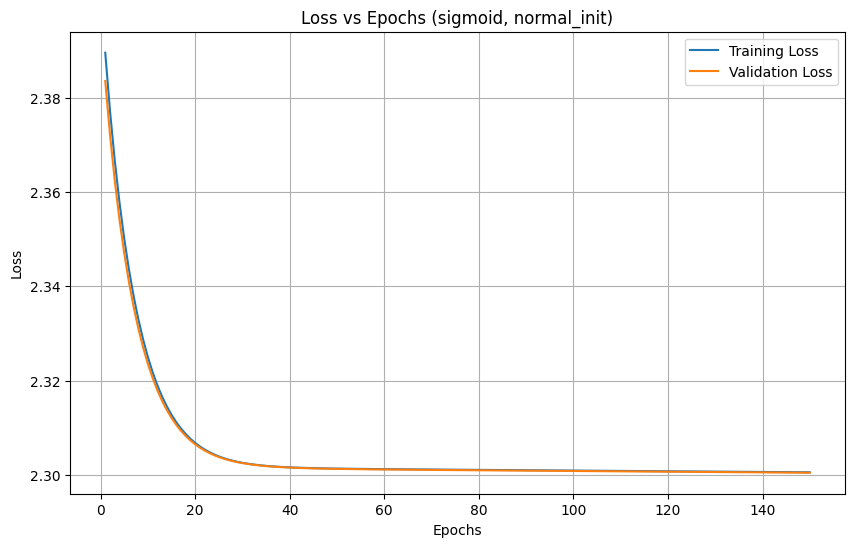

Training completed for activation: sigmoid, weight_init: normal_init
Model saved as model_sigmoid_normal_init.pkl
Loss curve displayed above.

Training with activation: tanh, weight_init: zero_init
Epoch 1/150, Train Loss: 2.3026, Val Loss: 2.3026
Epoch 50/150, Train Loss: 2.3018, Val Loss: 2.3018
Epoch 100/150, Train Loss: 2.3014, Val Loss: 2.3014
Epoch 150/150, Train Loss: 2.3012, Val Loss: 2.3012


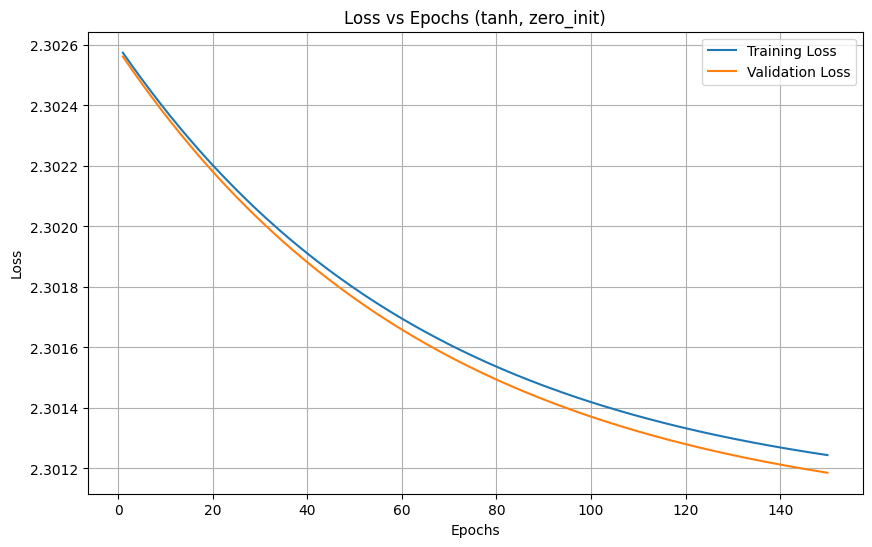

Training completed for activation: tanh, weight_init: zero_init
Model saved as model_tanh_zero_init.pkl
Loss curve displayed above.

Training with activation: tanh, weight_init: random_init
Epoch 1/150, Train Loss: 2.2921, Val Loss: 2.1967
Epoch 50/150, Train Loss: 0.6574, Val Loss: 0.6540
Epoch 100/150, Train Loss: 0.4705, Val Loss: 0.4689
Epoch 150/150, Train Loss: 0.3947, Val Loss: 0.3933


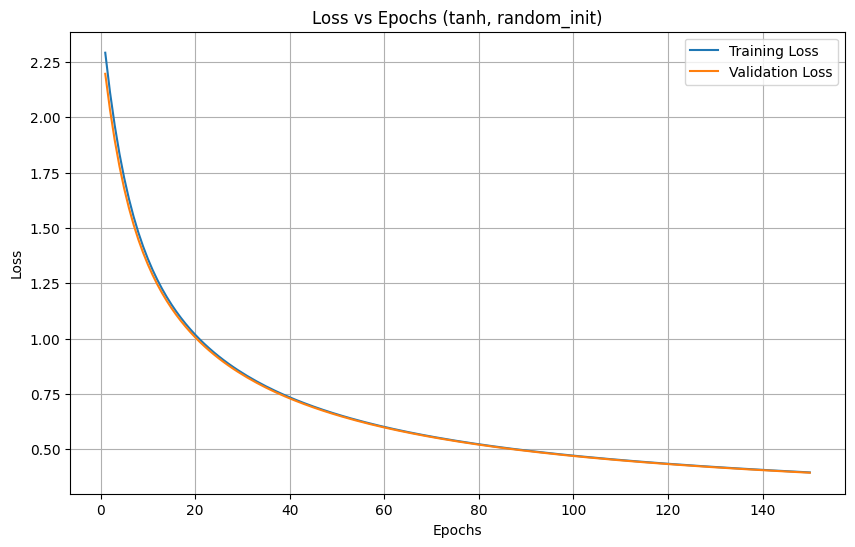

Training completed for activation: tanh, weight_init: random_init
Model saved as model_tanh_random_init.pkl
Loss curve displayed above.

Training with activation: tanh, weight_init: normal_init
Epoch 1/150, Train Loss: 2.2705, Val Loss: 2.1684
Epoch 50/150, Train Loss: 0.7194, Val Loss: 0.7084
Epoch 100/150, Train Loss: 0.5031, Val Loss: 0.4949
Epoch 150/150, Train Loss: 0.4126, Val Loss: 0.4064


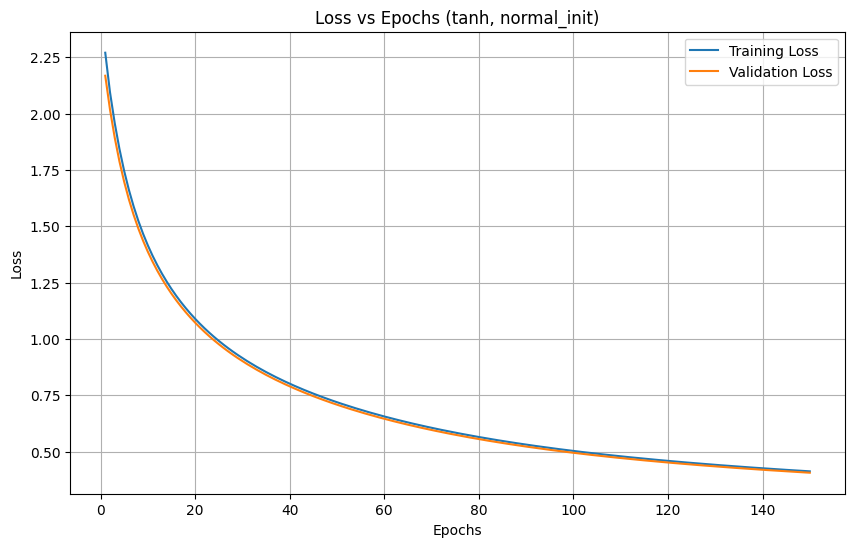

Training completed for activation: tanh, weight_init: normal_init
Model saved as model_tanh_normal_init.pkl
Loss curve displayed above.

Training with activation: relu, weight_init: zero_init
Epoch 1/150, Train Loss: 2.3026, Val Loss: 2.3026
Epoch 50/150, Train Loss: 2.3018, Val Loss: 2.3018
Epoch 100/150, Train Loss: 2.3014, Val Loss: 2.3014
Epoch 150/150, Train Loss: 2.3012, Val Loss: 2.3012


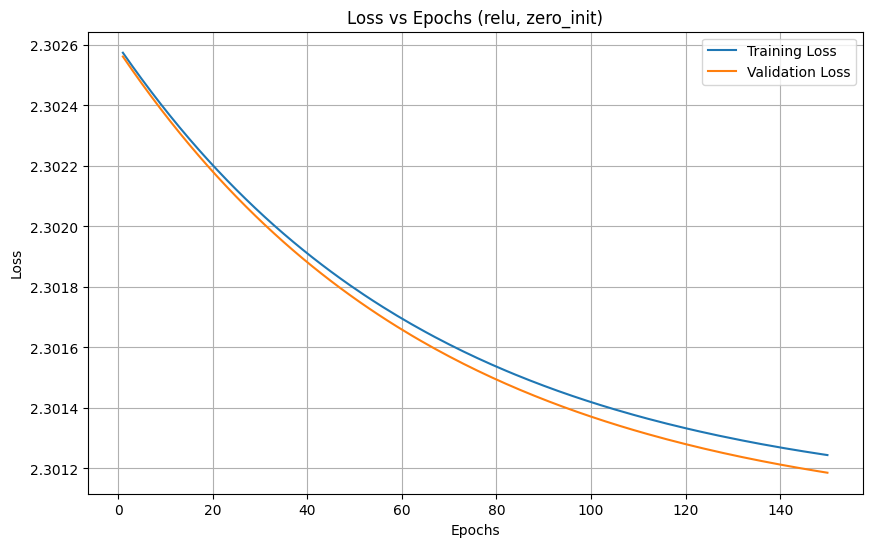

Training completed for activation: relu, weight_init: zero_init
Model saved as model_relu_zero_init.pkl
Loss curve displayed above.

Training with activation: relu, weight_init: random_init
Epoch 1/150, Train Loss: 2.3065, Val Loss: 2.2987
Epoch 50/150, Train Loss: 0.9781, Val Loss: 0.9624
Epoch 100/150, Train Loss: 0.4428, Val Loss: 0.4383
Epoch 150/150, Train Loss: 0.3463, Val Loss: 0.3416


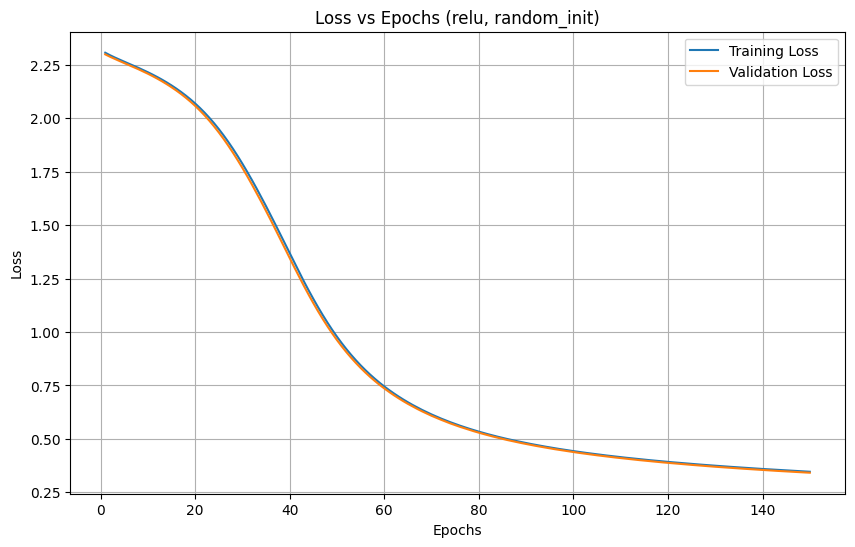

Training completed for activation: relu, weight_init: random_init
Model saved as model_relu_random_init.pkl
Loss curve displayed above.

Training with activation: relu, weight_init: normal_init
Epoch 1/150, Train Loss: 2.2895, Val Loss: 2.2848
Epoch 50/150, Train Loss: 0.8922, Val Loss: 0.8841
Epoch 100/150, Train Loss: 0.4457, Val Loss: 0.4452
Epoch 150/150, Train Loss: 0.3421, Val Loss: 0.3398


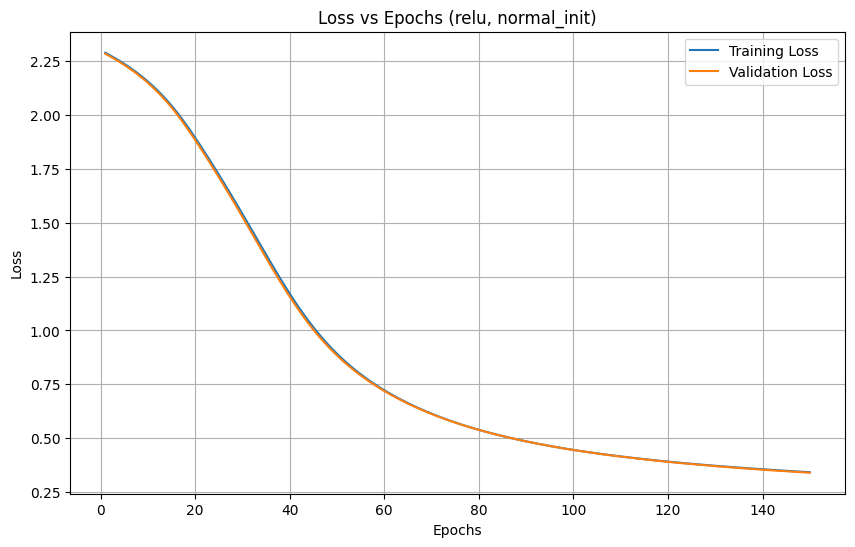

Training completed for activation: relu, weight_init: normal_init
Model saved as model_relu_normal_init.pkl
Loss curve displayed above.

Training with activation: leaky_relu, weight_init: zero_init
Epoch 1/150, Train Loss: 2.3026, Val Loss: 2.3026
Epoch 50/150, Train Loss: 2.3018, Val Loss: 2.3018
Epoch 100/150, Train Loss: 2.3014, Val Loss: 2.3014
Epoch 150/150, Train Loss: 2.3012, Val Loss: 2.3012


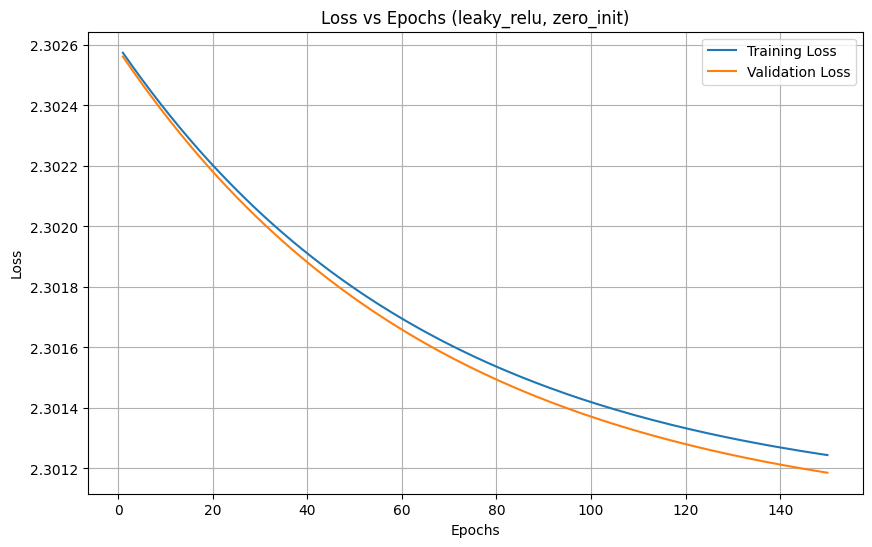

Training completed for activation: leaky_relu, weight_init: zero_init
Model saved as model_leaky_relu_zero_init.pkl
Loss curve displayed above.

Training with activation: leaky_relu, weight_init: random_init
Epoch 1/150, Train Loss: 2.3261, Val Loss: 2.3181
Epoch 50/150, Train Loss: 0.8978, Val Loss: 0.8820
Epoch 100/150, Train Loss: 0.4311, Val Loss: 0.4298
Epoch 150/150, Train Loss: 0.3318, Val Loss: 0.3318


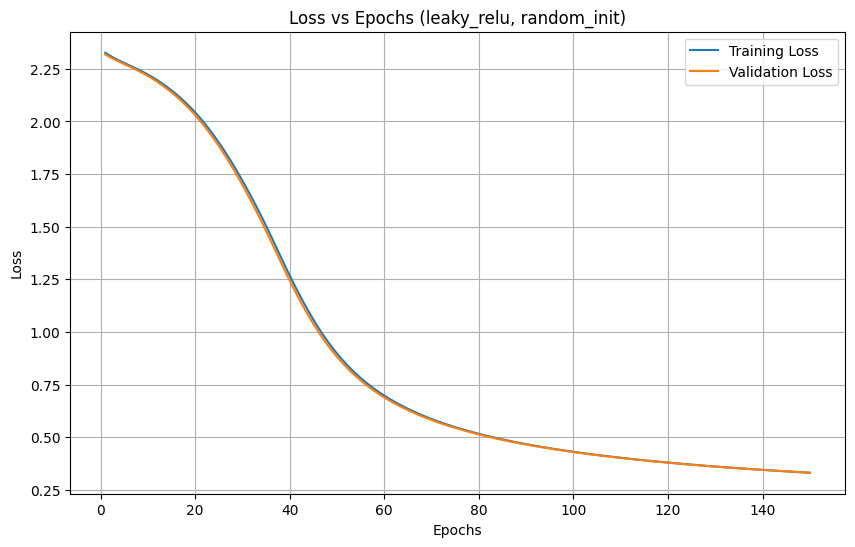

Training completed for activation: leaky_relu, weight_init: random_init
Model saved as model_leaky_relu_random_init.pkl
Loss curve displayed above.

Training with activation: leaky_relu, weight_init: normal_init
Epoch 1/150, Train Loss: 2.3183, Val Loss: 2.3111
Epoch 50/150, Train Loss: 0.9708, Val Loss: 0.9630
Epoch 100/150, Train Loss: 0.4614, Val Loss: 0.4622
Epoch 150/150, Train Loss: 0.3515, Val Loss: 0.3514


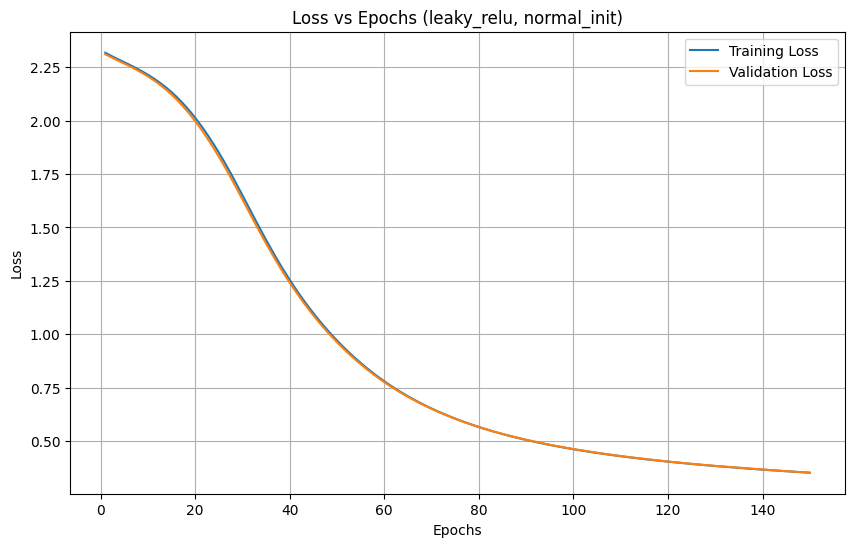

Training completed for activation: leaky_relu, weight_init: normal_init
Model saved as model_leaky_relu_normal_init.pkl
Loss curve displayed above.


In [ ]:
#  Model Training and Evaluation

# Configurations
activation_functions = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
weight_inits = {
    'zero_init': zero_init,
    'random_init': random_init,
    'normal_init': normal_init
}
num_hidden_layers = 4
layer_sizes = [256, 128, 64, 32]
input_size = X_train.shape[1]
output_size = Y_train.shape[1]
epochs = 150
batch_size = 128
learning_rate = 2e-4

# Add input and output layer sizes
layers = [input_size] + layer_sizes + [output_size]

# Dictionary to store loss histories
loss_histories = {}

# Training loop for each combination
for activation in activation_functions:
    for init_name, init_func in weight_inits.items():
        print(f"\nTraining with activation: {activation}, weight_init: {init_name}")
        
        # Initialize the neural network
        nn = NeuralNetwork(
            N=len(layers),
            layers=layers,
            lr=learning_rate,
            activation=activation,
            weight_init=init_func,
            epochs=epochs,
            batch_size=batch_size
        )
        
        # Train the network and record loss histories
        nn.fit(X_train, Y_train, X_val, Y_val,50)
        
        # Store the loss histories
        key = f"{activation}_{init_name}"
        loss_histories[key] = {
            'train_loss': nn.train_loss_history,
            'val_loss': nn.val_loss_history
        }
        
        # Plotting the loss curves
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(nn.train_loss_history)+1), nn.train_loss_history, label='Training Loss')
        plt.plot(range(1, len(nn.val_loss_history)+1), nn.val_loss_history, label='Validation Loss')
        plt.title(f"Loss vs Epochs ({activation}, {init_name})")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()  # Display the plot inline
        plt.close()  # Close the figure to free up memory
        
        # Save the trained model
        model_filename = f"model_{activation}_{init_name}.pkl"
        with open(model_filename, 'wb') as f:
            pickle.dump(nn, f)
        
        print(f"Training completed for activation: {activation}, weight_init: {init_name}")
        print(f"Model saved as {model_filename}")
        print(f"Loss curve displayed above.")


In [94]:
import pickle
import os

# Directory where the .pkl files are stored
model_dir = "./"  # Adjust this to the directory where the models are saved

# Function to load models and evaluate their accuracy
def evaluate_saved_models(model_dir, X_test, y_test):
    # List all .pkl files in the directory
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.pkl')]

    print("Evaluating saved models:")
    for model_file in model_files:
        model_path = os.path.join(model_dir, model_file)
        
        # Load the model from the .pkl file
        with open(model_path, 'rb') as file:
            model = pickle.load(file)

        # Evaluate the loaded model on the test set
        test_accuracy = model.score(X_test, Y_test)
        print(f"Model {model_file}: Test Accuracy = {test_accuracy:.4f}")

# Call the function to evaluate the models
evaluate_saved_models(model_dir, X_test, y_test)


Evaluating saved models:
Model model_leaky_relu_normal_init.pkl: Test Accuracy = 0.9017
Model model_leaky_relu_random_init.pkl: Test Accuracy = 0.9045
Model model_leaky_relu_zero_init.pkl: Test Accuracy = 0.1067
Model model_relu_normal_init.pkl: Test Accuracy = 0.9015
Model model_relu_random_init.pkl: Test Accuracy = 0.9028
Model model_relu_zero_init.pkl: Test Accuracy = 0.1067
Model model_sigmoid_normal_init.pkl: Test Accuracy = 0.1067
Model model_sigmoid_random_init.pkl: Test Accuracy = 0.1067
Model model_sigmoid_zero_init.pkl: Test Accuracy = 0.1067
Model model_tanh_normal_init.pkl: Test Accuracy = 0.8995
Model model_tanh_random_init.pkl: Test Accuracy = 0.8998
Model model_tanh_zero_init.pkl: Test Accuracy = 0.1067
